# Importing

In [0]:
import pets

In [0]:
import tensorflow as tf
import tarfile
import urllib
import os
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

data_dir = 'data/'
if not os.path.isdir(data_dir):
  os.mkdir(data_dir)

In [7]:
tf.test.gpu_device_name()

'/device:GPU:0'

# Cats Vs Dogs

In [8]:
pets.download_and_extract('data','.')

In [9]:
class_to_index = {'cat': 0, 'dog': 1}
index_to_class = {0: 'cat', 1: 'dog'}

train_annot, count_train = pets.cats_vs_dogs_annotations('data/annotations/trainval.txt')
test_annot, count_test = pets.cats_vs_dogs_annotations('data/annotations/test.txt')

print('Training examples count:', count_train)
print('Test examples count:', count_test)

Training examples count: 3680
Test examples count: 3669


# Get Random Batch

In [0]:
image_dir = '/content/data/images/'

def get_random_batch(annot, batch_size=4):
    all_keys = list(annot.keys())
    total_examples = len(all_keys)
    
    indices = np.random.choice(range(total_examples), batch_size)

    x = np.zeros((batch_size, 128, 128, 3))
    y = np.zeros((batch_size,1))
    images = []

    for i, index in enumerate(indices):
      image_path = os.path.join(image_dir, all_keys[index])
      image = tf.keras.preprocessing.image.load_img(
          image_path, target_size = (128,128)
      )
      arr = tf.keras.preprocessing.image.img_to_array(image)
      arr = tf.keras.applications.mobilenet_v2.preprocess_input(arr)
      arr = np.expand_dims(arr,axis=0)
      #print(arr.shape)
      x[i] = arr
      y[i] = class_to_index[annot[all_keys[index]]]
      images.append(image)

    return x,y,images

Displaying first 8 examples..


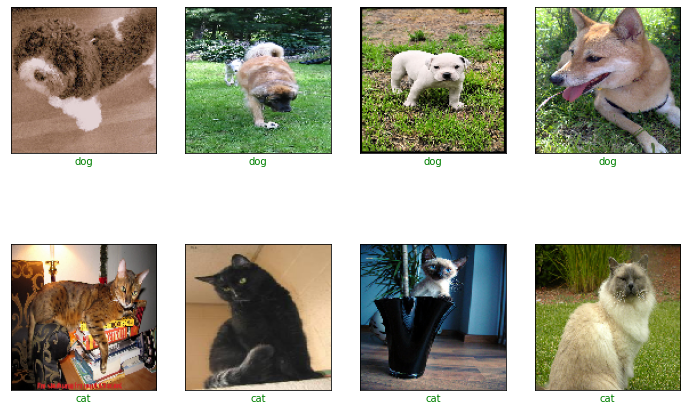

In [12]:
x,y,images = get_random_batch(train_annot, batch_size=8)
pets.display_examples(x,y,y,images,index_to_class).show()

# Create Model

In [13]:
mnet = tf.keras.applications.mobilenet_v2.MobileNetV2(
      include_top=False, pooling='avg',
      weights = 'imagenet', input_shape=(128,128,3)
)
#mnet.summary()

9412608/9406464 [==============================] - 0s 0us/step


In [21]:
def create_model():
  model = tf.keras.models.Sequential([
      mnet,
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(1, activation='sigmoid')
    ])
  model.layers[0].trainable = False
  model.compile(loss = 'binary_crossentropy', optimizer = 'adam',
                metrics=['accuracy'])
  return model

model = create_model()
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_128 (Model) (None, 1280)              2257984   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


# Model Training

In [0]:
def data_generator(batch_size, annot):
  while True:
    x,y,_ = get_random_batch(annot,batch_size)
    yield (x,y)

In [16]:
batch_size = 32
steps_per_epoch = int(count_train/batch_size)
validation_steps = int(count_train/batch_size)

print('Training Steps:', steps_per_epoch)
print('Validation steps:', validation_steps)

Training Steps: 115
Validation steps: 115


In [17]:
%%time

_ = model.fit_generator(
    data_generator(batch_size, train_annot),
    validation_data=data_generator(batch_size, test_annot),
    steps_per_epoch=steps_per_epoch,
    validation_steps=validation_steps,
    epochs =1 
)

Instructions for updating:
Please use Model.fit, which supports generators.
115/115 [==============================] - 41s 354ms/step - loss: 0.2477 - accuracy: 0.8995 - val_loss: 0.0908 - val_accuracy: 0.9777
CPU times: user 47.6 s, sys: 1.7 s, total: 49.3 s
Wall time: 50.3 s


# Predictions

In [0]:
x, y, images = get_random_batch(test_annot, batch_size=8)
preds = model.predict(x)

Displaying first 8 examples..


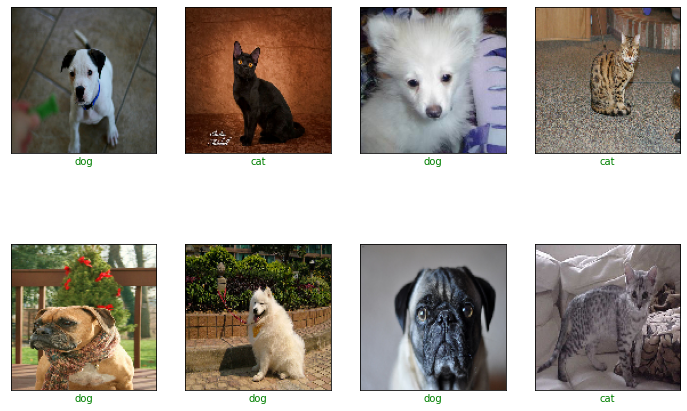

In [20]:
pets.display_examples(x, y, preds, images, index_to_class).show()